In [ ]:
!pip install deeplake

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Dropout
from tensorflow.keras.models import Model
import deeplake
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [2]:
ds = deeplake.load("hub://activeloop/mnist-train")

/

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/mnist-train



-

hub://activeloop/mnist-train loaded successfully.



In [3]:
labels = np.array(ds['labels'])
images = np.array(ds['images'])

In [4]:
# Разбиение данных на тренировочный и тестовый наборы
mnist_train_X, mnist_test_X, mnist_train_y, mnist_test_y = train_test_split(images, labels, test_size=0.2, random_state=42)

In [5]:
mnist_train_X = mnist_train_X / 255
mnist_test_X = mnist_test_X / 255

In [6]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

filtered_train_images = train_images[train_labels < 5]
filtered_test_images = test_images[test_labels < 5]
filtered_train_labels = train_labels[train_labels < 5]
filtered_test_labels = test_labels[test_labels < 5]

4422102/4422102 [==============================] - 0s 0us/step


In [7]:
fashion_train_X = filtered_train_images / 255
fashion_test_X = filtered_test_images / 255

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

# Задание 1
Обучиться на mnist цифрах и перенести модель, дообучить на mnist одежда (5 классов)

In [ ]:
# Архитектура сверточного автоэнкодера
input_img = Input(shape=(28, 28, 1))  # MNIST - черно-белые изображения

# Энкодер
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Декодер
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
flattened = Flatten()(decoded)
out = Dense(10, activation='softmax')(flattened)

optimizer = Adam(learning_rate=0.001)
# Сборка автоэнкодера
autoencoder = Model(input_img, out)
autoencoder.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Предполагается, что mnist_train и mnist_test имеют размерность (num_samples, 28, 28)
# Мы просто изменяем размерность данных для соответствия форме (num_samples, 28, 28, 1)
mnist_train = mnist_train_X.reshape(-1, 28, 28, 1)
mnist_test = mnist_test_X.reshape(-1, 28, 28, 1)

In [ ]:
mnist_train_y = tf.keras.utils.to_categorical(mnist_train_y, 10)
mnist_test_y = tf.keras.utils.to_categorical(mnist_test_y, 10)

In [ ]:
autoencoder.fit(mnist_train, mnist_train_y,
                epochs=25,
                batch_size=100,
                validation_data=(mnist_test, mnist_test_y))

Epoch 1/25
480/480 [==============================] - 165s 340ms/step - loss: 0.3956 - accuracy: 0.8762 - val_loss: 0.0994 - val_accuracy: 0.9728
Epoch 2/25
480/480 [==============================] - 135s 280ms/step - loss: 0.0875 - accuracy: 0.9735 - val_loss: 0.0712 - val_accuracy: 0.9793
Epoch 3/25
480/480 [==============================] - 135s 281ms/step - loss: 0.0604 - accuracy: 0.9818 - val_loss: 0.0579 - val_accuracy: 0.9824
Epoch 4/25
480/480 [==============================] - 135s 281ms/step - loss: 0.0470 - accuracy: 0.9856 - val_loss: 0.0506 - val_accuracy: 0.9844
Epoch 5/25
480/480 [==============================] - 131s 272ms/step - loss: 0.0370 - accuracy: 0.9884 - val_loss: 0.0498 - val_accuracy: 0.9852
Epoch 6/25
480/480 [==============================] - 135s 281ms/step - loss: 0.0307 - accuracy: 0.9903 - val_loss: 0.0384 - val_accuracy: 0.9883
Epoch 7/25
480/480 [==============================] - 131s 273ms/step - loss: 0.0261 - accuracy: 0.9920 - val_loss: 0.0408 -

In [ ]:
predicted_labels = autoencoder.predict(mnist_test)

375/375 [==============================] - 10s 25ms/step


In [ ]:
from sklearn.metrics import classification_report

prediction_y = np.argmax(predicted_labels, axis=-1)
mnist_test_y_1 = np.argmax(mnist_test_y, axis=-1)
# Получаем отчет о классификации
report = classification_report(mnist_test_y_1, prediction_y)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1175
           1       1.00      1.00      1.00      1322
           2       0.99      0.99      0.99      1174
           3       0.99      0.98      0.99      1219
           4       0.99      0.99      0.99      1176
           5       0.99      0.99      0.99      1104
           6       0.99      1.00      0.99      1177
           7       0.99      0.99      0.99      1299
           8       0.99      0.99      0.99      1160
           9       0.99      0.98      0.99      1194

    accuracy                           0.99     12000
   macro avg       0.99      0.99      0.99     12000
weighted avg       0.99      0.99      0.99     12000



In [ ]:
new_autoencoder_fashion = Model(input_img, autoencoder.layers[-1].output)
for layer in new_autoencoder_fashion.layers:
    layer.trainable = False

x = Dense(128, activation='relu')(flattened)
predictions = Dense(5, activation='softmax')(x)

fashion_model_from_numbers = Model(input_img, predictions)
fashion_model_from_numbers.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
fashion_model_from_numbers.fit(fashion_train_X, filtered_train_labels,
                               epochs=35,
                               batch_size=100,
                               validation_data=(fashion_test_X, filtered_test_labels))

# Предсказание
predictions_from_numbers = fashion_model_from_numbers.predict(fashion_test_X)

Epoch 1/35
300/300 [==============================] - 26s 84ms/step - loss: 0.4535 - accuracy: 0.8232 - val_loss: 0.3909 - val_accuracy: 0.8538
Epoch 2/35
300/300 [==============================] - 25s 83ms/step - loss: 0.3611 - accuracy: 0.8612 - val_loss: 0.3761 - val_accuracy: 0.8534
Epoch 3/35
300/300 [==============================] - 25s 84ms/step - loss: 0.3356 - accuracy: 0.8704 - val_loss: 0.3414 - val_accuracy: 0.8770
Epoch 4/35
300/300 [==============================] - 27s 90ms/step - loss: 0.3177 - accuracy: 0.8789 - val_loss: 0.3405 - val_accuracy: 0.8722
Epoch 5/35
300/300 [==============================] - 23s 75ms/step - loss: 0.3002 - accuracy: 0.8843 - val_loss: 0.3252 - val_accuracy: 0.8790
Epoch 6/35
300/300 [==============================] - 24s 81ms/step - loss: 0.2861 - accuracy: 0.8909 - val_loss: 0.3274 - val_accuracy: 0.8774
Epoch 7/35
300/300 [==============================] - 26s 88ms/step - loss: 0.2774 - accuracy: 0.8934 - val_loss: 0.3031 - val_accuracy:

In [ ]:
prediction_fashion_y = np.argmax(predictions_from_numbers, axis=-1)
# Получаем отчет о классификации
report = classification_report(filtered_test_labels, prediction_fashion_y)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1000
           1       0.98      0.97      0.98      1000
           2       0.86      0.79      0.82      1000
           3       0.89      0.89      0.89      1000
           4       0.79      0.87      0.83      1000

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



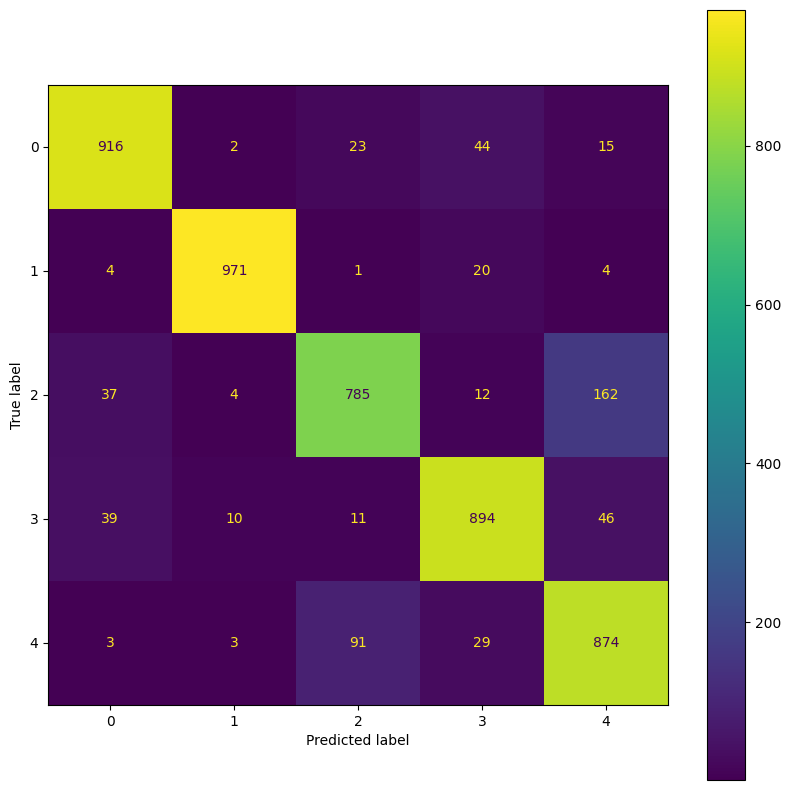

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Вычисляем confusion matrix
cm = confusion_matrix(filtered_test_labels, prediction_fashion_y)

# Визуализируем confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4]).plot(ax=ax)
plt.show()

# Задание 2
Обучиться на мнист цифры с self target и перенести на одежду (5 классов)



In [ ]:
# ЗАДАНИЕ 2

# Архитектура сверточного автоэнкодера
input_img = Input(shape=(28, 28, 1))  # MNIST - черно-белые изображения

# Энкодер
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Декодер
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

optimizer = Adam(learning_rate=0.01)
# Сборка автоэнкодера
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')

# Предполагается, что mnist_train и mnist_test имеют размерность (num_samples, 28, 28)
# Мы просто изменяем размерность данных для соответствия форме (num_samples, 28, 28, 1)
mnist_train = mnist_train_X.reshape(-1, 28, 28, 1)
mnist_test = mnist_test_X.reshape(-1, 28, 28, 1)

In [ ]:
# Обучение автоэнкодера
autoencoder.fit(mnist_train, mnist_train,
                epochs=35,
                batch_size=256,
                validation_data=(mnist_test, mnist_test))

Epoch 1/35
188/188 [==============================] - 166s 695ms/step - loss: 0.1495 - val_loss: 0.0843
Epoch 2/35
188/188 [==============================] - 129s 689ms/step - loss: 0.0805 - val_loss: 0.0779
Epoch 3/35
188/188 [==============================] - 128s 680ms/step - loss: 0.0762 - val_loss: 0.0752
Epoch 4/35
188/188 [==============================] - 132s 702ms/step - loss: 0.0742 - val_loss: 0.0732
Epoch 5/35
188/188 [==============================] - 135s 719ms/step - loss: 0.0730 - val_loss: 0.0722
Epoch 6/35
188/188 [==============================] - 130s 692ms/step - loss: 0.0720 - val_loss: 0.0714
Epoch 7/35
188/188 [==============================] - 127s 678ms/step - loss: 0.0716 - val_loss: 0.0708
Epoch 8/35
188/188 [==============================] - 130s 691ms/step - loss: 0.0709 - val_loss: 0.0703
Epoch 9/35
188/188 [==============================] - 132s 703ms/step - loss: 0.0704 - val_loss: 0.0700
Epoch 10/35
188/188 [==============================] - 128s 684m

375/375 [==============================] - 9s 24ms/step


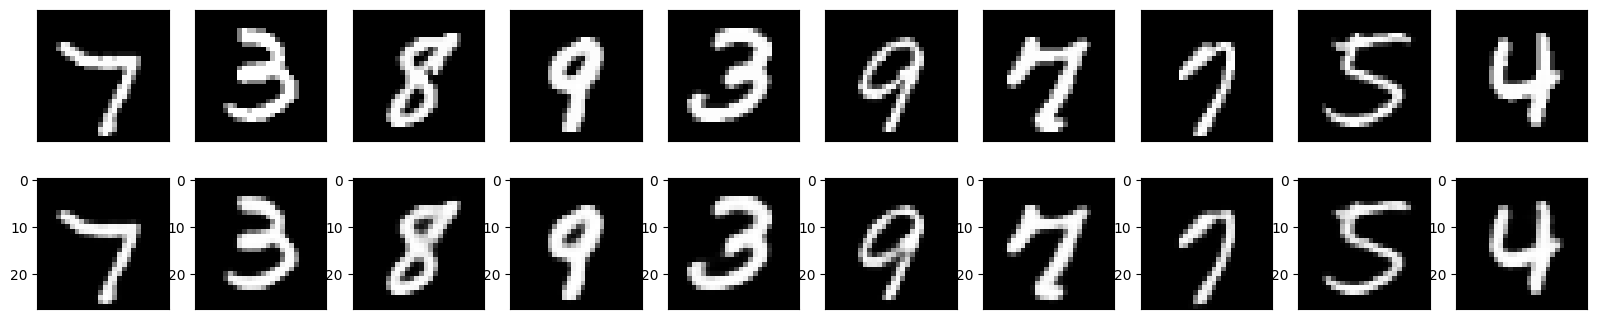

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Предсказание на тестовом наборе данных
decoded_imgs = autoencoder.predict(mnist_test)

n = 10  # количество изображений для отображения
plt.figure(figsize=(20, 4))

for i in range(n):
    # Отображение оригинальных изображений
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(mnist_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Отображение восстановленных изображений
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)

In [ ]:
new_autoencoder = Model(input_img, decoded)
for layer in new_autoencoder.layers:
    layer.trainable = False

flattened = Flatten()(encoded)
x = Dense(128, activation='relu')(flattened)
predictions = Dense(5, activation='softmax')(x)

fashion_model = Model(input_img, predictions)
fashion_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
fashion_model.fit(fashion_train_X, filtered_train_labels,
                  epochs=35,
                  batch_size=256,
                  validation_data=(fashion_test_X, filtered_test_labels))

# Предсказание
predictions = fashion_model.predict(fashion_test_X)

Epoch 1/35
118/118 [==============================] - 12s 96ms/step - loss: 0.5254 - accuracy: 0.8146 - val_loss: 0.3842 - val_accuracy: 0.8654
Epoch 2/35
118/118 [==============================] - 11s 97ms/step - loss: 0.3354 - accuracy: 0.8795 - val_loss: 0.3657 - val_accuracy: 0.8632
Epoch 3/35
118/118 [==============================] - 11s 94ms/step - loss: 0.3059 - accuracy: 0.8893 - val_loss: 0.3234 - val_accuracy: 0.8858
Epoch 4/35
118/118 [==============================] - 11s 94ms/step - loss: 0.2870 - accuracy: 0.8974 - val_loss: 0.3113 - val_accuracy: 0.8882
Epoch 5/35
118/118 [==============================] - 10s 81ms/step - loss: 0.2771 - accuracy: 0.8998 - val_loss: 0.2909 - val_accuracy: 0.8962
Epoch 6/35
118/118 [==============================] - 11s 96ms/step - loss: 0.2742 - accuracy: 0.9009 - val_loss: 0.2999 - val_accuracy: 0.8908
Epoch 7/35
118/118 [==============================] - 11s 93ms/step - loss: 0.2616 - accuracy: 0.9044 - val_loss: 0.2811 - val_accuracy:

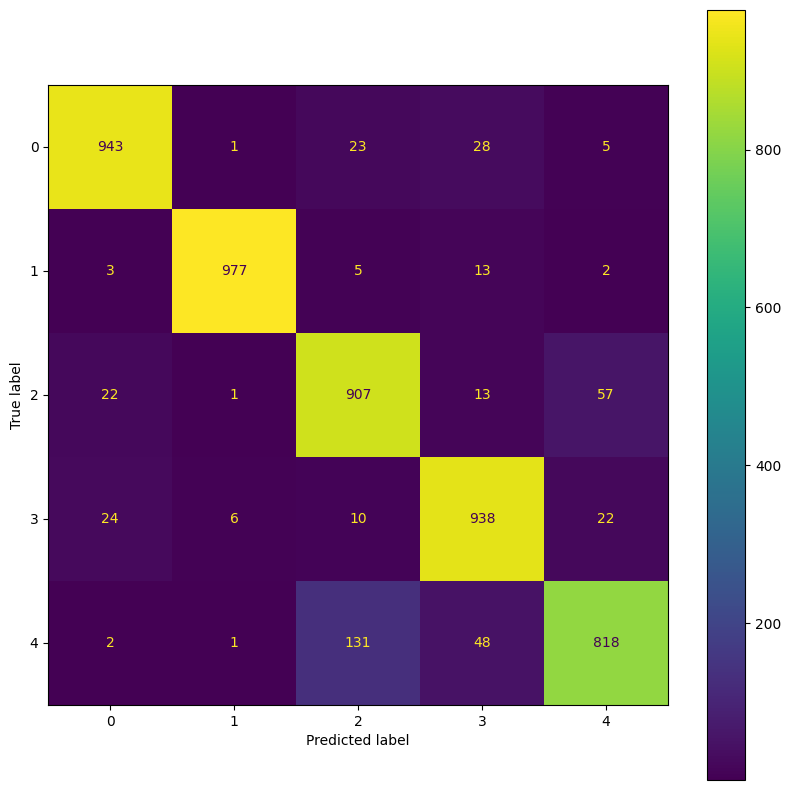

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Получаем предсказанные метки классов из вероятностных предсказаний
predicted_labels = np.argmax(predictions, axis=-1)

# Вычисляем confusion matrix
cm = confusion_matrix(filtered_test_labels, predicted_labels)

# Визуализируем confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4]).plot(ax=ax)
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(filtered_test_labels, predicted_labels, average='macro')

# Print the metrics
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Precision: 0.92
Recall: 0.92
F1-score: 0.92


In [ ]:
# Получаем отчет о классификации
report = classification_report(filtered_test_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1000
           1       0.99      0.98      0.98      1000
           2       0.84      0.91      0.87      1000
           3       0.90      0.94      0.92      1000
           4       0.90      0.82      0.86      1000

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000



# Задание 3
Попробовать сделать полносвязную сеть для классификации mnist цифры

In [ ]:
# Загрузка и предобработка данных
(mnist_train_X, mnist_train_y), (mnist_test_X, mnist_test_y) = tf.keras.datasets.mnist.load_data()

# Нормализация данных
mnist_train = mnist_train_X.astype('float32') / 255.
mnist_test = mnist_test_X.astype('float32') / 255.

mnist_train = mnist_train.reshape(-1, 28, 28, 1)
mnist_test = mnist_test.reshape(-1, 28, 28, 1)

# Архитектура автоэнкодера
input_img = Input(shape=(28, 28, 1))
x = Flatten()(input_img)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
encoded = Dense(128, activation='relu')(x)

x = Dense(256, activation='relu')(encoded)
x = Dense(512, activation='relu')(x)
x = Dense(28*28, activation='sigmoid')(x)
decoded = Reshape((28, 28, 1))(x)

autoencoder = Model(input_img, decoded)

optimizer = Adam(learning_rate=0.001)
# Обучение автоэнкодера на MNIST
autoencoder.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
autoencoder.fit(mnist_train, mnist_train,
                epochs=50,
                batch_size=512,
                validation_data=(mnist_test, mnist_test))

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/50
118/118 [==============================] - 14s 97ms/step - loss: 0.0631 - accuracy: 0.7888 - val_loss: 0.0335 - val_accuracy: 0.8061
Epoch 2/50
118/118 [==============================] - 12s 105ms/step - loss: 0.0275 - accuracy: 0.8095 - val_loss: 0.0215 - val_accuracy: 0.8104
Epoch 3/50
118/118 [==============================] - 12s 99ms/step - loss: 0.0195 - accuracy: 0.8126 - val_loss: 0.0169 - val_accuracy: 0.8119
Epoch 4/50
118/118 [==============================] - 9s 76ms/step - loss: 0.0161 - accuracy: 0.8136 - val_loss: 0.0146 - val_accuracy: 0.8127
Epoch 5/50
118/118 [==============================] - 10s 89ms/step - loss: 0.0142 - accuracy: 0.8140 - val_loss: 0.0131 - val_accuracy: 0.8129
Epoch 6/50
118/118 [==============================] - 11s 95ms/step - loss: 0.0126 - accuracy: 0.8143 - val_loss: 0.0118 - val_accuracy: 0.8135
Epoch 7/50
118/118 [==============================] - 10s 85ms/step - l

313/313 [==============================] - 2s 7ms/step


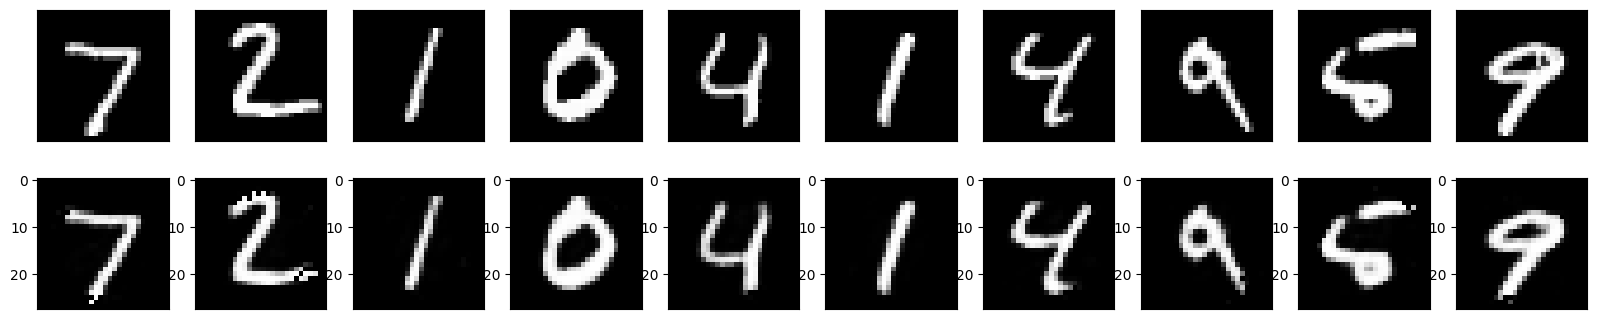

In [ ]:
# Предсказание на тестовом наборе данных
decoded_imgs = autoencoder.predict(mnist_test)

n = 10  # количество изображений для отображения
plt.figure(figsize=(20, 4))

for i in range(n):
    # Отображение оригинальных изображений
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(mnist_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Отображение восстановленных изображений
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)

In [ ]:
new_autoencoder = Model(input_img, decoded)
for layer in new_autoencoder.layers:
    layer.trainable = False

flattened = Flatten()(encoded)
x = Dense(128, activation='relu')(flattened)
predictions = Dense(10, activation='softmax')(x)

model = Model(input_img, predictions)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(mnist_train, mnist_train_y,
          epochs=30,
          batch_size=256,
          validation_data=(mnist_test, mnist_test_y))

# Предсказание
predictions = model.predict(mnist_test)

Epoch 1/30
235/235 [==============================] - 3s 12ms/step - loss: 0.8139 - accuracy: 0.7570 - val_loss: 0.3988 - val_accuracy: 0.8818
Epoch 2/30
235/235 [==============================] - 3s 13ms/step - loss: 0.3585 - accuracy: 0.8933 - val_loss: 0.3069 - val_accuracy: 0.9109
Epoch 3/30
235/235 [==============================] - 3s 15ms/step - loss: 0.3024 - accuracy: 0.9105 - val_loss: 0.2734 - val_accuracy: 0.9215
Epoch 4/30
235/235 [==============================] - 3s 11ms/step - loss: 0.2696 - accuracy: 0.9206 - val_loss: 0.2626 - val_accuracy: 0.9212
Epoch 5/30
235/235 [==============================] - 3s 11ms/step - loss: 0.2436 - accuracy: 0.9290 - val_loss: 0.2195 - val_accuracy: 0.9341
Epoch 6/30
235/235 [==============================] - 3s 11ms/step - loss: 0.2182 - accuracy: 0.9363 - val_loss: 0.1943 - val_accuracy: 0.9425
Epoch 7/30
235/235 [==============================] - 3s 14ms/step - loss: 0.2004 - accuracy: 0.9417 - val_loss: 0.1864 - val_accuracy: 0.9462

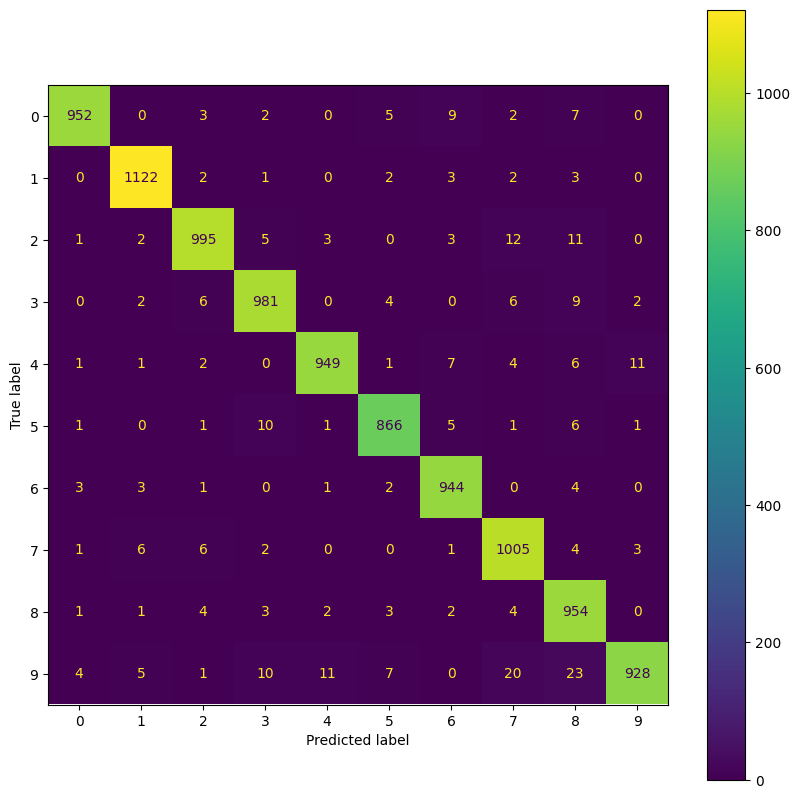

In [ ]:
# Получаем предсказанные метки классов из вероятностных предсказаний
predicted_labels = np.argmax(predictions, axis=-1)

# Вычисляем confusion matrix
cm = confusion_matrix(mnist_test_y, predicted_labels)

# Визуализируем confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot(ax=ax)
plt.show()

In [ ]:
# Получаем отчет о классификации
report = classification_report(mnist_test_y, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.96      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.97      0.97       892
           6       0.97      0.99      0.98       958
           7       0.95      0.98      0.96      1028
           8       0.93      0.98      0.95       974
           9       0.98      0.92      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



# Pipeline

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from tensorflow import keras

In [10]:
# Загрузка и предобработка данных
(mnist_train_X, mnist_train_y), (mnist_test_X, mnist_test_y) = tf.keras.datasets.mnist.load_data()

# Нормализация данных
mnist_train = mnist_train_X.astype('float32') / 255.
mnist_test = mnist_test_X.astype('float32') / 255.

mnist_train = mnist_train.reshape(-1, 28, 28, 1)
mnist_test = mnist_test.reshape(-1, 28, 28, 1)

11490434/11490434 [==============================] - 0s 0us/step


In [11]:
class NeuralNetworkTrainer(BaseEstimator, TransformerMixin):
    def __init__(self, epochs_1=50, learning_rate=0.01, batch_size_1=200, epochs_2=50, batch_size_2=200, verbose=0):
        self.epochs_1 = epochs_1
        self.learning_rate = learning_rate
        self.batch_size_1 = batch_size_1
        self.epochs_2 = epochs_2
        self.batch_size_2 = batch_size_2
        self.verbose = verbose
        self.model = None

    def fit(self, X, y=None):
        # Архитектура сверточного автоэнкодера
        input_img = Input(shape=(28, 28, 1))

        # Архитектура автоэнкодера
        input_img = Input(shape=(28, 28, 1))
        x = Flatten()(input_img)
        x = Dense(512, activation='relu')(x)
        x = Dense(256, activation='relu')(x)
        encoded = Dense(128, activation='relu')(x)

        x = Dense(256, activation='relu')(encoded)
        x = Dense(512, activation='relu')(x)
        x = Dense(28*28, activation='sigmoid')(x)
        decoded = Reshape((28, 28, 1))(x)

        autoencoder = Model(input_img, decoded)

        optimizer = Adam(learning_rate=self.learning_rate)
        # Сборка автоэнкодера
        autoencoder.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
        autoencoder.fit(X, X, epochs=self.epochs_1, batch_size=self.batch_size_1, verbose=self.verbose)

        new_autoencoder = Model(input_img, decoded)
        for layer in new_autoencoder.layers:
            layer.trainable = False

        flattened = Flatten()(encoded)
        x = Dense(128, activation='relu')(flattened)
        predictions = Dense(10, activation='softmax')(x)

        model = Model(input_img, predictions)
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X, y, epochs=self.epochs_2, batch_size=self.batch_size_2, verbose=self.verbose)
        self.model = model
        return self

    def transform(self, X):
        return X

    def predict(self, X):
        if self.model is None:
            raise ValueError("Модель не обучена")
        y_pred = self.model.predict(X)
        y_pred = np.argmax(y_pred, axis=-1)
        return y_pred

    def score(self, X, y=None):
        if self.model is None:
            raise ValueError("Модель не обучена")
        y_pred = self.model.predict(X)
        y_pred = np.argmax(y_pred, axis=-1)
        y = np.argmax(y, axis=-1)
        f1 = f1_score(y, y_pred, average='weighted')
        return f1

In [12]:
param = {
    'epochs_1': 50,
    'learning_rate': 0.001,
    'batch_size_1': 512,
    'epochs_2': 30,
    'batch_size_2': 256,
    'verbose': 1
}

neural_network = NeuralNetworkTrainer(**param)
pipe = Pipeline([
    ('neural_network_trainer', neural_network)
])

pipe.fit(mnist_train, mnist_train_y)

Epoch 1/50
118/118 [==============================] - 11s 73ms/step - loss: 0.0659 - accuracy: 0.7876
Epoch 2/50
118/118 [==============================] - 10s 84ms/step - loss: 0.0306 - accuracy: 0.8094
Epoch 3/50
118/118 [==============================] - 14s 116ms/step - loss: 0.0219 - accuracy: 0.8123
Epoch 4/50
118/118 [==============================] - 10s 81ms/step - loss: 0.0180 - accuracy: 0.8133
Epoch 5/50
118/118 [==============================] - 9s 75ms/step - loss: 0.0157 - accuracy: 0.8138
Epoch 6/50
118/118 [==============================] - 10s 85ms/step - loss: 0.0140 - accuracy: 0.8141
Epoch 7/50
118/118 [==============================] - 10s 83ms/step - loss: 0.0130 - accuracy: 0.8143
Epoch 8/50
118/118 [==============================] - 9s 75ms/step - loss: 0.0122 - accuracy: 0.8145
Epoch 9/50
118/118 [==============================] - 11s 90ms/step - loss: 0.0115 - accuracy: 0.8146
Epoch 10/50
118/118 [==============================] - 10s 87ms/step - loss: 0.0109

Pipeline(steps=[('neural_network_trainer',
                 NeuralNetworkTrainer(batch_size_1=512, batch_size_2=256,
                                      epochs_2=30, learning_rate=0.001,
                                      verbose=1))])

In [13]:
# Предсказание
predictions = pipe.predict(mnist_test)

313/313 [==============================] - 1s 4ms/step


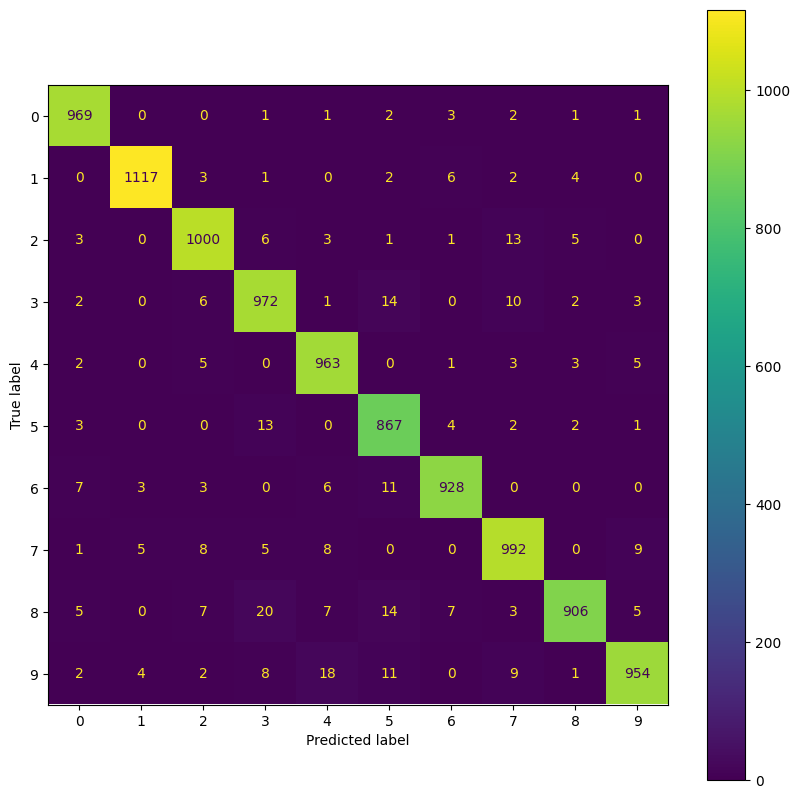

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Вычисляем confusion matrix
cm = confusion_matrix(mnist_test_y, predictions)

# Визуализируем confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot(ax=ax)
plt.show()

In [16]:
from sklearn.metrics import classification_report

# Получаем отчет о классификации
report = classification_report(mnist_test_y, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.98      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.95      0.96      0.95      1010
           4       0.96      0.98      0.97       982
           5       0.94      0.97      0.96       892
           6       0.98      0.97      0.97       958
           7       0.96      0.96      0.96      1028
           8       0.98      0.93      0.95       974
           9       0.98      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

